In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
from utility import utility
import plotly.graph_objects as go
import warnings
import scipy.stats as stats
warnings.filterwarnings("ignore")

In [27]:
data = utility.collect_yf("EURUSD", "7d", "1m")

[*********************100%***********************]  1 of 1 completed


In [28]:
df_comp = data.copy()
df_comp.set_index("datetime", inplace=True)
df_comp=df_comp.sort_index()

In [29]:
len(df_comp)

9302

# Test for stationarity

In [30]:
# Splitting data in training and testing
size = int(len(df_comp)*0.9)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

# Testing stationarity
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df.close)

for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))


There isn't enough proves to reject that data isn't stationary with a 0.99% of confidence
There isn't enough proves to reject that data isn't stationary with a 0.95% of confidence
There isn't enough proves to reject that data isn't stationary with a 0.90% of confidence


In [31]:
## Functions

def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

# create a N-order differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    history = list(history)
    n = len(yhat)
    if len(yhat) == 1:
        value = yhat[i] + history[-interval]
        history.append(value)
    else:
        value = yhat[0] + history[-interval]
        history.append(value)
        
        for i in range(1, n):
            value = yhat[i] + history[-interval]
            history.append(value)
    return np.array(history[-n:])

In [32]:
x = df.close.values

# Regarding 1 ordered differenced time serie
differenced = difference(x, 1)

# Testing stationarity
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(differenced)

for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


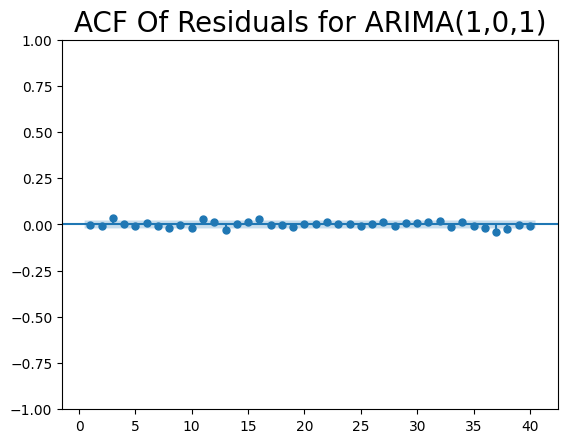

In [33]:
## ARIMA(1,0,1)

model_ar_1_i_0_ma_1 = ARIMA(differenced, order=(1,0,1))
results_ar_1_i_0_ma_1 = model_ar_1_i_0_ma_1.fit()
results_ar_1_i_0_ma_1.summary()

## Residuals of the ARIMA(1,0,1)

df['res_ar_1_i_0_ma_1'] = np.concatenate([0,results_ar_1_i_0_ma_1.resid], axis=None)
sgt.plot_acf(df.res_ar_1_i_0_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,0,1)",size=20)
plt.show()

In [41]:
def arima(p,d,q):
    ## ARIMA(1,0,1)

    x = df.close.values

    # Regarding 1 ordered differenced time serie
    differenced = difference(x, 1)
    model_ar_1_i_0_ma_1 = ARIMA(differenced, order=(p,d,q))
    results_ar_1_i_0_ma_1 = model_ar_1_i_0_ma_1.fit()
    return results_ar_1_i_0_ma_1

In [43]:
results_ar_5_i_0_ma_5_differenced = arima(5,0,5)
results_ar_3_i_0_ma_5_differenced = arima(3,0,5)
results_ar_5_i_0_ma_3_differenced = arima(5,0,3)
results_ar_5_i_0_ma_4_differenced = arima(5,0,4)
results_ar_4_i_0_ma_5_differenced = arima(4,0,5)
print("ARIMA(5,0,5):  \t LL = ", results_ar_5_i_0_ma_5_differenced.llf, "\t AIC = ", results_ar_5_i_0_ma_5_differenced.aic)

print("ARIMA(5,0,4):  \t LL = ", results_ar_5_i_0_ma_4_differenced.llf, "\t AIC = ", results_ar_4_i_0_ma_5_differenced.aic)

print("ARIMA(4,0,5):  \t LL = ", results_ar_4_i_0_ma_5_differenced.llf, "\t AIC = ", results_ar_4_i_0_ma_5_differenced.aic)

print("ARIMA(5,0,3):  \t LL = ", results_ar_5_i_0_ma_3_differenced.llf, "\t AIC = ", results_ar_5_i_0_ma_3_differenced.aic)

print("ARIMA(3,0,5):  \t LL = ", results_ar_3_i_0_ma_5_differenced.llf, "\t AIC = ", results_ar_3_i_0_ma_5_differenced.aic)

ARIMA(5,0,5):  	 LL =  61572.329595042 	 AIC =  -123120.659190084
ARIMA(5,0,4):  	 LL =  61572.27341512599 	 AIC =  -123393.25587533116
ARIMA(4,0,5):  	 LL =  61707.62793766558 	 AIC =  -123393.25587533116
ARIMA(5,0,3):  	 LL =  61706.786286652605 	 AIC =  -123393.57257330521
ARIMA(3,0,5):  	 LL =  61707.61083621138 	 AIC =  -123395.22167242276


In [44]:
model_ar_5_i_0_ma_5_differenced = ARIMA(differenced, order=(5,0,5))
results_ar_5_i_0_ma_5_differenced = model_ar_5_i_0_ma_5_differenced.fit()
results_ar_5_i_0_ma_5_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8370
Model:                 ARIMA(5, 0, 5)   Log Likelihood               61572.330
Date:                Fri, 16 Jun 2023   AIC                        -123120.659
Time:                        14:51:47   BIC                        -123036.270
Sample:                             0   HQIC                       -123091.840
                               - 8370                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.983e-06   1.64e-06      1.815      0.069   -2.37e-07     6.2e-06
ar.L1              -0   8.89e-11         -0      1.000   -1.74e-10    1.74e-10
ar.L2              -0    6.9e-12         -0      1.000   -1.35e-11    1.35e-11
ar.L3              -0   2.72e-11         -0      1.000   -5.33e-11    5.33e-11
ar.L4              -0   2.51e-11         -0      1.000   -4.91e-11    4.91e-11
ar.L5               0   7.29e-12          0      1.000   -1.43e-11    1.43e-11
ma.L1               0   8.89e-11          0      1.000   -1.74e-10    1.74e-10
ma.L2               0    6.9e-12          0      1.000   -1.35e-11    1.35e-11
ma.L3               0   2.72e-11          0      1.000   -5.33e-11    5.33e-11
ma.L4               0   2.51e-11          0      1.000   -4.91e-11    4.91e-11
ma.L5              -0   7.29e-12         -0      1.000   -1.43e-11    1.43e-11
sigma2      2.312e-08   8.26e-11    279.854      0.000     2.3e-08    2.33e-08
===================================================================================
Ljung-Box (L1) (Q):                 218.35   Jarque-Bera (JB):            397278.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.31e+27. Standard errors may be unstable.
"""